In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

In [3]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [4]:
import random as python_random
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

In [5]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train/'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val/'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test/'


In [6]:
train_num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
train_num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"train_num_pneumonia: {train_num_pneumonia}")
print(f"train_num_normal: {train_num_normal}")

val_num_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
val_num_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f"val_num_pneumonia: {val_num_pneumonia}")
print(f"val_num_normal: {val_num_normal}")

test_num_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
test_num_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f"test_num_pneumonia: {test_num_pneumonia}")
print(f"test_num_normal: {test_num_normal}")

print("")
train_num = train_num_pneumonia+train_num_normal
val_num = val_num_pneumonia+val_num_normal
test_num = test_num_pneumonia+test_num_normal
print(f"train_num: {train_num}")
print(f"val_num: {val_num}")
print(f"test_num: {test_num}")

print("")
num_pneumonia = train_num_pneumonia + test_num_pneumonia + val_num_pneumonia
num_normal = train_num_normal + test_num_normal + val_num_normal
print(f"num_pneumonia: {num_pneumonia}")
print(f"num_normal: {num_normal}")

train_num_pneumonia: 3875
train_num_normal: 1341
val_num_pneumonia: 8
val_num_normal: 8
test_num_pneumonia: 390
test_num_normal: 234

train_num: 5216
val_num: 16
test_num: 624

num_pneumonia: 4273
num_normal: 1583


In [7]:
labels = ["NORMAL", "PNEUMONIA"]
img_size = 224

def load_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
                
    return np.array(data, dtype="object")

In [8]:
train = load_data(train_dir)
test = load_data(test_dir)
val = load_data(val_dir)

In [9]:
X_train = [] 
y_train = []
X_test = [] 
y_test = []
X_val = [] 
y_val = []

def split_x_y(data, x, y):
    for feature, label in data:
        x.append(feature)
        y.append(label)
    return np.array(x), np.array(y)

X_train, y_train = split_x_y(train, X_train, y_train)
X_test, y_test = split_x_y(test, X_test, y_test)
X_val, y_val = split_x_y(val, X_val, y_val)

In [10]:
def augmentation_layers(x):
    x = keras.layers.Rescaling(1./255)(x)
    x = keras.layers.RandomRotation(0.05)(x)
    return x

In [11]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               mode='min')

In [12]:
def visualise_model_metrics(model, history):
    evaluation = model.evaluate(x=X_test,y=y_test)
    print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

    evaluation = model.evaluate(x=X_train,y=y_train)
    print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")
    
    plt.figure(figsize=(20,15))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label = "Training accuracy",marker='o')
    plt.plot(history.history['val_accuracy'], label="Validation accuracy",marker='o')
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(2,2,2)
    plt.plot(history.history['loss'], label = "Training loss",marker='o')
    plt.plot(history.history['val_loss'], label="Validation loss",marker='o')
    plt.legend()
    plt.title("Training vs validation loss")

    plt.show()

In [13]:
def load_classification_report(y_pred):
    print('Classification report')
    print()
    print(classification_report(y_true=y_test,y_pred=y_pred, target_names=labels))

In [13]:
def plot_roc(y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [14]:
base_resnet50 = tf.keras.applications.ResNet50(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_resnet50.layers:
        layer.trainable=False

94765736/94765736 [==============================] - 4s 0us/step


In [15]:
inputs = keras.layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_resnet50(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(1,activation='sigmoid')(x)
resnet50 = keras.Model(inputs, predictions)

In [16]:
resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [18]:
checkpoint_resnet50 = '/kaggle/working/resnet50_weights.hdf5'

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_resnet50,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_res50 = resnet50.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

resnet50.load_weights(checkpoint_resnet50)

Weight for class 0: 0.73
Weight for class 1: 0.27
Epoch 1/30
163/163 [==============================] - 19s 64ms/step - loss: 0.0978 - accuracy: 0.8936 - val_loss: 0.3405 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 9s 57ms/step - loss: 0.0654 - accuracy: 0.9350 - val_loss: 0.2605 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 9s 56ms/step - loss: 0.0529 - accuracy: 0.9471 - val_loss: 0.1607 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - 9s 54ms/step - loss: 0.0463 - accuracy: 0.9540 - val_loss: 0.2439 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 9s 56ms/step - loss: 0.0444 - accuracy: 0.9567 - val_loss: 0.0930 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 6/30
163/163 [==============================] - 9s 56ms/step - loss: 0.0451 - accuracy: 0.9523 - val_loss: 0.1138 - val_accuracy: 0.9375 - lr: 

20/20 [==============================] - 2s 62ms/step - loss: 0.3509 - accuracy: 0.8846
Test Accuracy: 88.46%
163/163 [==============================] - 9s 54ms/step - loss: 0.1169 - accuracy: 0.9519
Train Accuracy: 95.19%


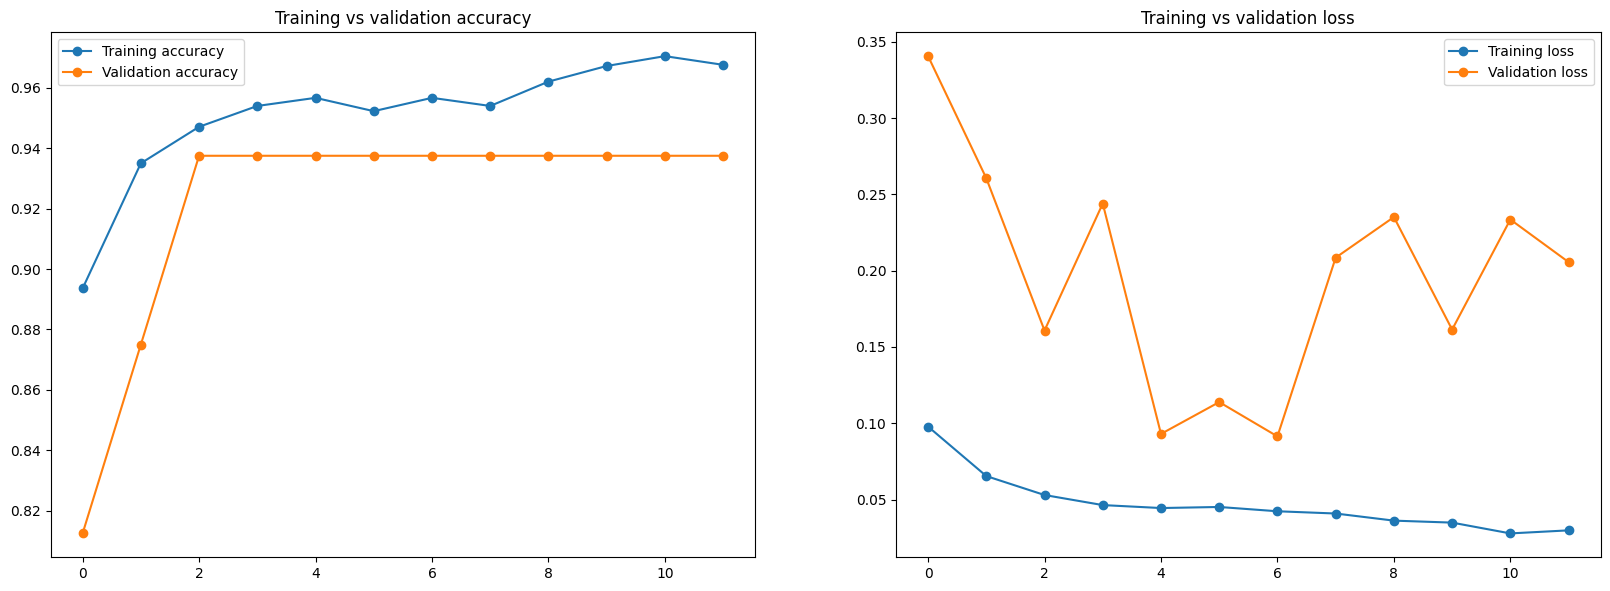

In [19]:
visualise_model_metrics(resnet50, history_res50)

20/20 [==============================] - 2s 50ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.91      0.77      0.83       234
   PNEUMONIA       0.88      0.95      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.89      0.88      0.88       624



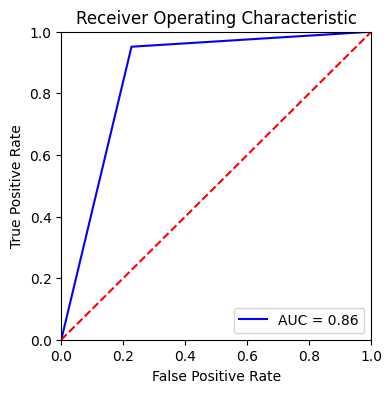

In [20]:
pred = resnet50.predict(X_test)
resnet50_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(resnet50_pred)
plot_roc(resnet50_pred)

In [21]:
#DenseNet
base_densenet121 = tf.keras.applications.DenseNet121(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_densenet121.layers:
        layer.trainable=False


29084464/29084464 [==============================] - 1s 0us/step


In [22]:
inputs = layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_densenet121(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
densenet121 = keras.Model(inputs, predictions)

In [23]:
densenet121.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [24]:
checkpoint_densenet121 = '/kaggle/working/densenet121_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_densenet121,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_densenet121 = densenet121.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

densenet121.load_weights(checkpoint_densenet121)

Epoch 1/30
163/163 [==============================] - 19s 73ms/step - loss: 0.2733 - accuracy: 0.7046 - val_loss: 0.8843 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 9s 58ms/step - loss: 0.1607 - accuracy: 0.8169 - val_loss: 0.8447 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 9s 55ms/step - loss: 0.1393 - accuracy: 0.8510 - val_loss: 1.1155 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.8648
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
163/163 [==============================] - 9s 55ms/step - loss: 0.1205 - accuracy: 0.8648 - val_loss: 1.7297 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 9s 56ms/step - loss: 0.1073 - accuracy: 0.8836 - val_loss: 1.2940 - val_accuracy: 0.6875 - lr: 6.0000e-05
Epoch 6/30
163/163 [==================

20/20 [==============================] - 4s 72ms/step - loss: 0.4059 - accuracy: 0.8381
Test Accuracy: 83.81%
163/163 [==============================] - 9s 56ms/step - loss: 0.3116 - accuracy: 0.8727
Train Accuracy: 87.27%


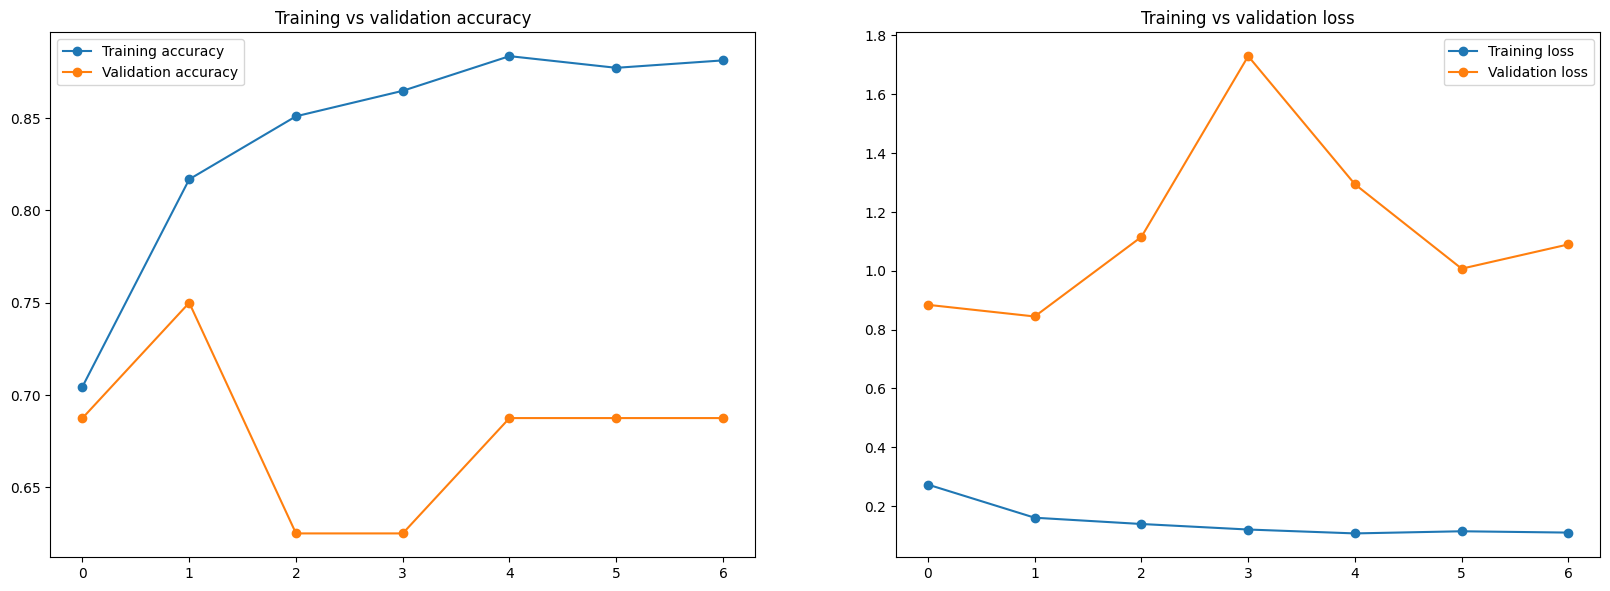

In [25]:
visualise_model_metrics(densenet121, history_densenet121)

20/20 [==============================] - 3s 51ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.76      0.82      0.79       234
   PNEUMONIA       0.89      0.85      0.87       390

    accuracy                           0.84       624
   macro avg       0.83      0.83      0.83       624
weighted avg       0.84      0.84      0.84       624



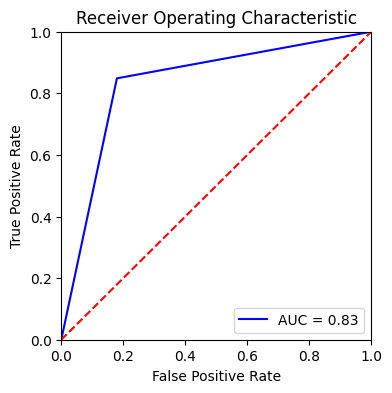

In [26]:
pred = densenet121.predict(X_test)
densenet121_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(densenet121_pred)
plot_roc(densenet121_pred)